In [1]:
from __future__ import division

from teext_network import (build_segmenter_simple,
                              preproc_dataset)
from train_utils import load_dataset, dataset_loc
import theano.tensor as T
from theano import function as tfn
import cPickle as pickle
import numpy as np
import time
import lasagne.layers as ll
from os.path import join


Couldn't import dot_parser, loading of dot files will not be possible.

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______

Trying /home/zach/envs/thesis/local/lib/python2.7/site-packages/flann-1.8.4-py2.7.egg/pyflann/lib/libflann.so


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)
/home/zach/envs/thesis/local/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
model_loc = 'annot_te_128'
dset_loc = 'annot_te_128'

In [3]:

model_name = 'small_lr1e-2.pkl'
with open(join(dataset_loc, "Flukes/patches/%s" % join(model_loc, model_name)), 'r') as f:
    model = pickle.load(f)

dset = load_dataset(join(dataset_loc, "Flukes/patches/%s" % dset_loc), normalize_method='zscore')

Loading /home/zach/data/Flukes/patches/annot_te_128
Took 221.78 seconds


In [4]:
X = T.tensor4()


segmenter = build_segmenter_simple()
ll.set_all_param_values(segmenter, model)
model_outputs = [ll.get_output(intr_layer, X, deterministic=True) for intr_layer in ll.get_all_layers(segmenter)]
#segmenter_out = ll.get_output(segmenter, X, deterministic=True)
segmenter_fn = tfn([X], model_outputs)

dset_for_model = {section:preproc_dataset(dset[section]) for section in ['train', 'valid', 'test']}

point_outputs = {sec:segmenter_fn(dset_for_model[sec]['X']) for sec in ['train','valid','test']}

In [5]:
list(enumerate(zip([(np.linalg.norm(i), i.shape) for i in ll.get_all_param_values(segmenter)],ll.get_all_params(segmenter))))

[(0, ((2.9597044, (4, 1, 7, 7)), conv1.W)),
 (1, ((0.60216594, (4,)), conv1.b)),
 (2, ((3.3170025, (8, 4, 5, 5)), conv2.W)),
 (3, ((0.53545636, (8,)), conv2.b)),
 (4, ((4.173317, (16, 8, 5, 5)), conv3.W)),
 (5, ((0.73736513, (16,)), conv3.b)),
 (6, ((3.4359546, (8, 16, 5, 5)), conv4.W)),
 (7, ((0.32147345, (8,)), conv4.b)),
 (8, ((3.0157335, (8, 8, 3, 3)), conv5.W)),
 (9, ((0.49274153, (8,)), conv5.b)),
 (10, ((2.5017316, (4, 8, 3, 3)), conv6.W)),
 (11, ((1.3252493, (4,)), conv6.b)),
 (12, ((2.2136021, (2, 4, 3, 3)), conv_final.W)),
 (13, ((0.35437217, (2,)), conv_final.b))]

In [6]:
[(ind, i.shape[1:], np.average(np.std(i,axis=0)), l.name) for (ind, i), l in zip(enumerate(point_outputs['valid']),ll.get_all_layers(segmenter))]

[(0, (1, 128, 128), 0.98288381, 'input'),
 (1, (4, 128, 128), 0.42106754, 'conv1'),
 (2, (8, 128, 128), 0.28742844, 'conv2'),
 (3, (16, 128, 128), 0.19339833, 'conv3'),
 (4, (8, 128, 128), 0.19712096, 'conv4'),
 (5, (8, 128, 128), 0.19126016, 'conv5'),
 (6, (4, 128, 128), 0.24386255, 'conv6'),
 (7, (2, 128, 128), 1.1171941, 'conv_final'),
 (8, (2, 128, 128), 0.10414581, '4dsoftmax')]

In [7]:
print(np.std(point_outputs['valid'][-1],axis=0))

[[[ 0.10431323  0.1223185   0.15470347 ...,  0.14942381  0.13252591
    0.15814325]
  [ 0.10724377  0.11545787  0.1440497  ...,  0.13870093  0.12668593
    0.1298103 ]
  [ 0.12398069  0.12570943  0.12999938 ...,  0.13020381  0.12972441
    0.1258036 ]
  ..., 
  [ 0.10434691  0.08803808  0.08589945 ...,  0.07424493  0.076136
    0.08649045]
  [ 0.0961738   0.08438124  0.08695309 ...,  0.05476347  0.05575043
    0.06404714]
  [ 0.10672198  0.06291785  0.05502153 ...,  0.07920317  0.08839218
    0.08738889]]

 [[ 0.10431322  0.1223185   0.15470347 ...,  0.14942382  0.13252591
    0.15814325]
  [ 0.10724378  0.11545787  0.1440497  ...,  0.1387009   0.12668592
    0.12981029]
  [ 0.12398066  0.12570943  0.12999941 ...,  0.1302038   0.1297244
    0.12580359]
  ..., 
  [ 0.10434689  0.08803808  0.08589945 ...,  0.07424492  0.076136
    0.08649047]
  [ 0.09617379  0.08438123  0.0869531  ...,  0.05476347  0.05575043
    0.06404711]
  [ 0.10672197  0.06291785  0.0550215  ...,  0.07920315  0.0883

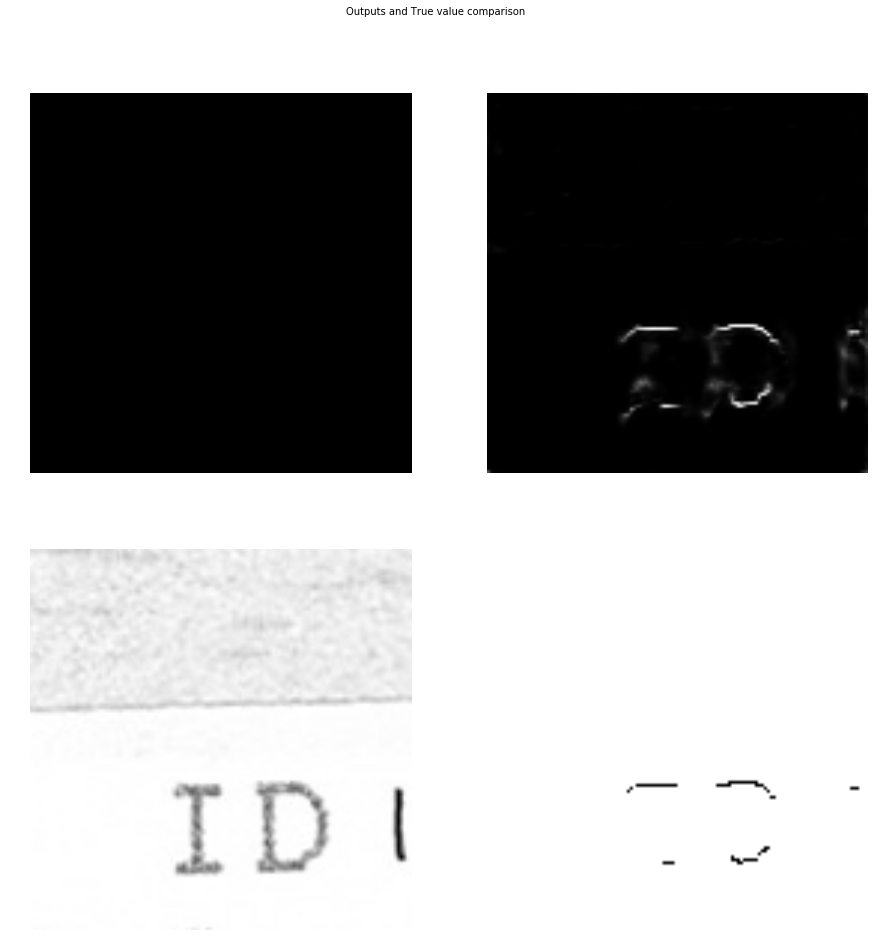

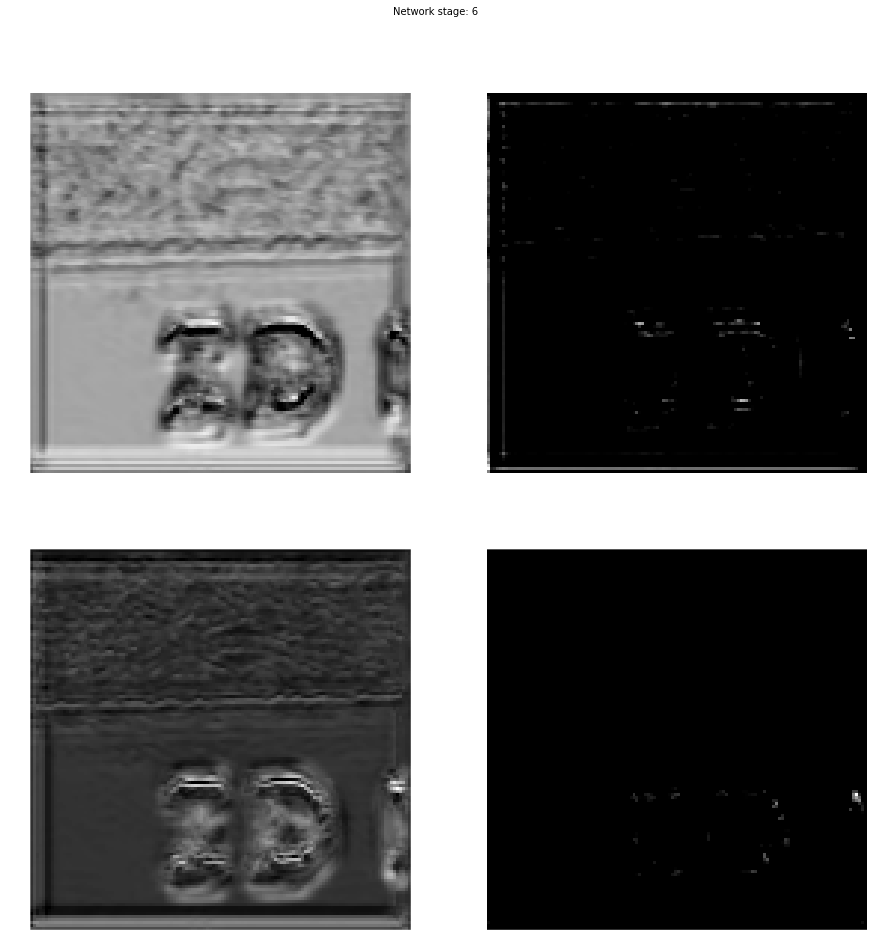

In [8]:
import matplotlib.pyplot as plt
import cv2
import random
%matplotlib inline

def show_output(originals, true_labels, outputs, ind, stage=-1, weights=None):
    # the [0] indexes into the channel
    dset_img = ((originals[ind][0]*dset['std']) + dset['mean']).astype(np.uint8)
    dset_label = true_labels[ind][0,:,:] # only show the trailing edge label
    
    pred_label = outputs[-1][ind]
    network_stage = outputs[stage][ind].swapaxes(0,2)
    #print(output)
    plt.gray()
    f, trueax = plt.subplots(2,2, figsize=(15,15))
    f.suptitle("Outputs and True value comparison")
    for i in trueax.flatten():
        i.axis('off')
    trueax[0,0].imshow(dset_label)
    trueax[0,1].imshow(pred_label[0,:,:])
    trueax[1,0].imshow(dset_img)
    #trueax[1,1].imshow(weights[ind])
    trueax[1,1].imshow(np.argmax(pred_label,axis=0))
    
    nfilters = network_stage.shape[-1]
    #print(nfilters)
    square_size = int(np.sqrt(nfilters) + 0.5)
    #print(square_size)
    plt.gray()
    if square_size > 1:
        f, netax = plt.subplots(square_size, square_size, figsize=(15,15))
        f.suptitle('Network stage: %d' % stage)

        for i in range(square_size*square_size):
            this_ax = netax[i // square_size, i % square_size]
            this_ax.axis('off')
            #this_ax.get_xaxis().set_visible(False)
            #this_ax.get_yaxis().set_visible(False)
            if i < nfilters:
                this_ax.imshow(network_stage[:,:,i].T, interpolation='none')
    else:
        # probably an input or stn
        #print(network_stage[:,:,0])
        #print(outputs[stage-1][ind].reshape(2,3))
        denormed =  (dset['std']*network_stage[:,:,0] + dset['mean']).astype(np.uint8).T
        #denormed = network_stage[:,:,0].astype(np.uint8)
        #print(denormed)

        f, netax = plt.subplots(1, figsize=(7.5,7.5))
        netax.axis('off')
        netax.imshow(denormed, interpolation='none')
    #ax[2].imshow(network_stage)

sec = 'valid'
show_output(dset_for_model[sec]['X'], dset_for_model[sec]['y'], point_outputs[sec], 
            random.choice(range(dset_for_model[sec]['X'].shape[0])), stage=6, weights=dset_for_model[sec]['pixelw'])

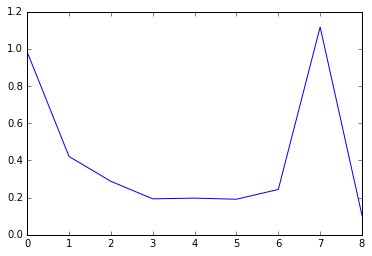

In [9]:
#print(len(point_outputs_valid))
n_layers = len(point_outputs[sec])
#plt.yscale('log')
plt.plot([np.average(np.std(point_outputs[sec][i],axis=0)) for i in range(n_layers)])

0.104146
0.0572179


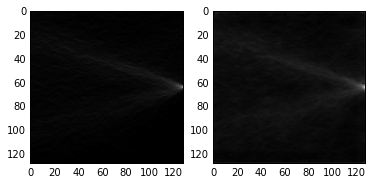

In [10]:
avg_label = np.average(dset_for_model[sec]['y'],axis=0)
avg_pred = np.average(point_outputs[sec][-1],axis=0)
f, ax = plt.subplots(1, 2)
ax[0].imshow(avg_label[0,:,:])
ax[1].imshow(avg_pred[0,:,:])

print(np.average(np.std(point_outputs[sec][-1],axis=0)))
print(np.average(np.std(dset_for_model[sec]['y'],axis=0)))

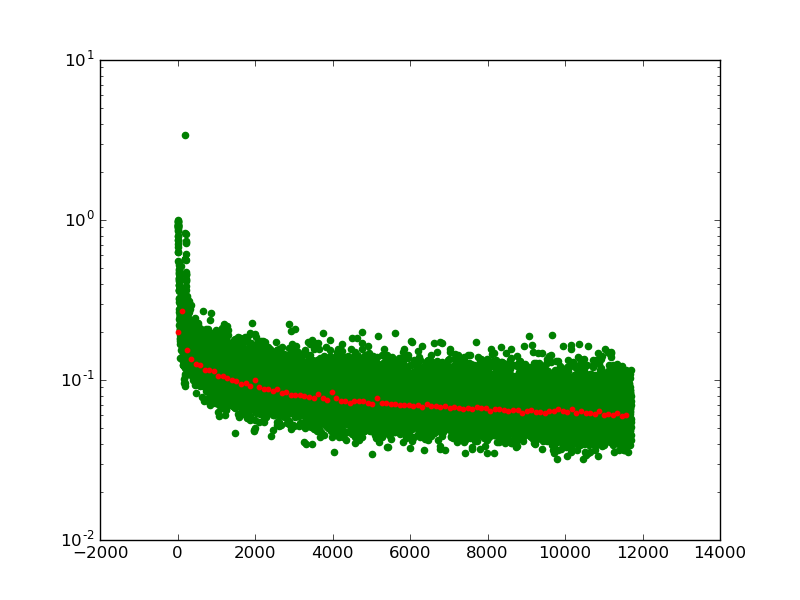

In [11]:
from IPython.display import Image 
Image(filename='./losses.png')

(1, 2, 458, 960)


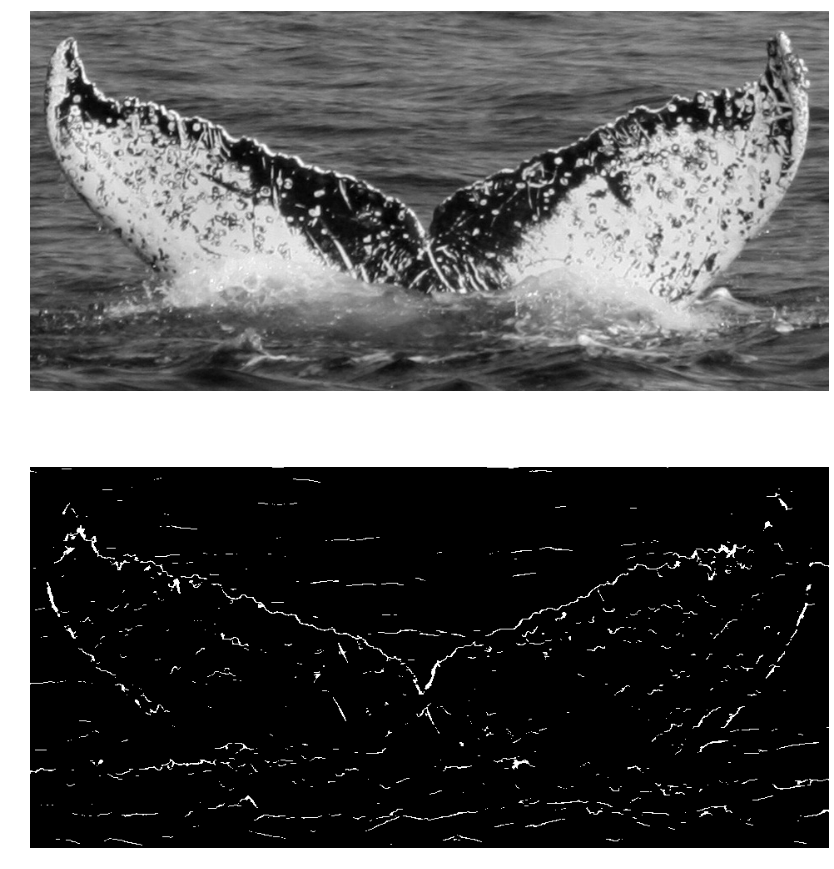

In [12]:
# Let's visualize a random image
imgs_dir = join(dataset_loc, 'Flukes/CRC_combined constrained')
import glob
zsl_imgs = glob.glob(join(imgs_dir, '*'))
rand_img = cv2.cvtColor(cv2.imread(random.choice(zsl_imgs)),cv2.COLOR_BGR2GRAY)
rand_img = (rand_img.astype(np.float32) - dset['mean']) / dset['std']
output_img = segmenter_fn(rand_img[np.newaxis,np.newaxis,:,:])[-1]
print(output_img.shape)
f, ax = plt.subplots(2, figsize=(15,15))
[i.axis('off') for i in ax]
ax[0].imshow(rand_img)
ax[1].imshow(output_img[0,0,:,:] > 0.5)


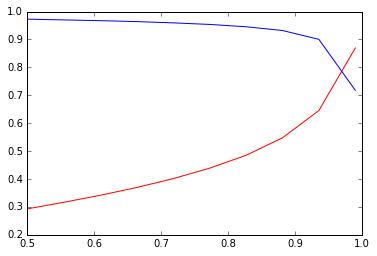

In [16]:
# false positive rate
def precision_recall(true, pred, pos_thresh=0.5):
    # given a set of predicted labels and true labels, figure out what the rate of false positive to true
    # positives is
    # assume decision axis is axis 1
    thresh = lambda x: x[:,0,:,:] > pos_thresh # this makes sense
    thresh_true = thresh(true)
    thresh_pred = thresh(pred)
    # now it's 0 where there's bg, and 1 where there's te
    # if we subtract true from pred, we'll have -1 for a false neg and 1 for a false pos
    n_tp = np.sum(np.logical_and(thresh_true, thresh_pred))
    n_tn = np.sum(1 - np.logical_and(thresh_true, thresh_pred))
    n_fp = np.sum((thresh_pred.astype(np.int) - thresh_true.astype(np.int)) > 0)
    n_fn = np.sum((thresh_pred.astype(np.int) - thresh_true.astype(np.int)) < 0)
    precision = (n_tp) / (n_tp + n_fp)
    recall = (n_tp) / (n_fn + n_tp)
    return precision, recall

thresholds = np.linspace(0.5,.99,10)
pr_curve = [precision_recall(dset_for_model[sec]['y'], point_outputs[sec][-1], pos_thresh=i) for i in thresholds]
plt.plot(thresholds, zip(*pr_curve)[0], color='r')
plt.plot(thresholds, zip(*pr_curve)[1], color='b')

In [17]:
# all bg accuracy?
np.sum(dset_for_model[sec]['y'][:,0,:,:] == np.zeros(dset_for_model[sec]['y'][:,0,:,:].shape,dtype=np.int)) / np.product(dset_for_model[sec]['y'][:,0,:,:].shape)

0.99564383509821786

In [ ]:
M = np.eye(3, dtype=np.float32)[:-1,:] + 0.5
test_img = dset['std']*dset_for_model[sec]['X'][0][0] + dset['mean']
plt.imshow(cv2.warpAffine(test_img, M, (128,128), 0, 0, cv2.BORDER_REPLICATE))